<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Practical 5 - Using a pre-trained convnet</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

In [1]:
from tensorflow import keras
print('keras: ', keras.__version__)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

keras:  2.2.4-tf


## Objectives
After completing this practical exercise, students should be able to utilize a pre-trained convnet through:
1. [Feature extraction without and with data augmentation](#fea)
2. [Fine Tuning](#fine)
3. [Exercise- utilize another pre-trained model](#exc)

## 1. Feature extraction <a id='fea' />

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

In our case, we use the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `tensorflow.keras.applications` module. Here's the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of `tensorflow.keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [2]:
from tensorflow.keras.applications import VGG16
img_size = 50

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

The final feature map has shape `(1, 1, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Feature extraction without data augmentation:
Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

* Feature extraction with data augmentation:
Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. 

### 1.1 Feature extraction without data augmentation
We will record the output of `conv_base` on our data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#update base_dir to path where you saved the cats_and_dogs_small dataset
base_dir = 'C:/School/NP/Np_class/DL/week04/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
print(train_features.shape)
print(train_labels.shape)

(2000, 1, 1, 512)
(2000,)


The extracted features are currently of shape `(samples, 1, 1, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 1 * 1 * 512)`:

In [6]:
train_features = np.reshape(train_features, (2000, 1 * 1 * 512))
validation_features = np.reshape(validation_features, (1000, 1 * 1 * 512))
test_features = np.reshape(test_features, (1000, 1 * 1 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(1 * 1 * 512,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 477us/sample - loss: 0.7557 - acc: 0.5120 - val_loss: 0.6866 - val_acc: 0.5650
Epoch 2/30
2000/2000 [==============================] - 0s 193us/sample - loss: 0.7438 - acc: 0.5315 - val_loss: 0.6745 - val_acc: 0.5920
Epoch 3/30
2000/2000 [==============================] - 0s 192us/sample - loss: 0.7177 - acc: 0.5470 - val_loss: 0.6627 - val_acc: 0.6120
Epoch 4/30
2000/2000 [==============================] - 0s 193us/sample - loss: 0.7121 - acc: 0.5590 - val_loss: 0.6531 - val_acc: 0.6210
Epoch 5/30
2000/2000 [==============================] - 0s 191us/sample - loss: 0.6925 - acc: 0.5890 - val_loss: 0.6447 - val_acc: 0.6340
Epoch 6/30
2000/2000 [==============================] - 0s 189us/sample - loss: 0.6639 - acc: 0.6225 - val_loss: 0.6372 - val_acc: 0.6460
Epoch 7/30
2000/2000 [==============================] - 0s 187us/sample - loss: 0.6731 - acc: 0.6010 - val_loss: 0.6303 - va

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

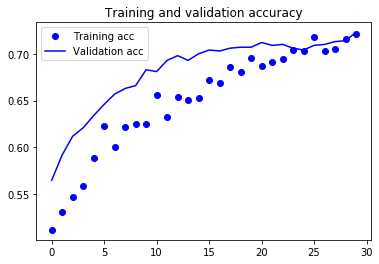

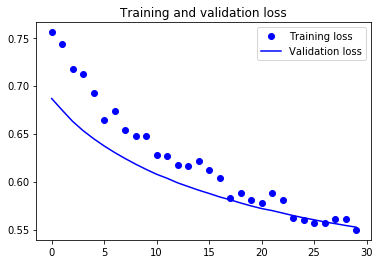

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We reach a validation accuracy of about 72%, much better than what we could achieve previously with our small model trained from 
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

### 1.2 Feature extraction with data augmentation

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this technique is very computationally expensive and the below program may take very long time to complete.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base) #VGG16 pretrained
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [12]:
conv_base.trainable = False

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


With this setup, only the weights from the two `Dense` layers that we added will be trained. Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6909 - acc: 0.5335 - val_loss: 0.6846 - val_acc: 0.5760
Epoch 2/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6775 - acc: 0.5710 - val_loss: 0.6673 - val_acc: 0.6190
Epoch 3/30
100/100 [==============================] - 10s 97ms/step - loss: 0.6623 - acc: 0.6090 - val_loss: 0.6538 - val_acc: 0.6300
Epoch 4/30
100/100 [==============================] - 9s 90ms/step - loss: 0.6509 - acc: 0.6415 - val_loss: 0.6430 - val_acc: 0.6480loss: 0.6527 - 
Epoch 5/30
100/100 [==============================] - 9s 89ms/step - loss: 0.6422 - acc: 0.6460 - val_loss: 0.6344 - val_acc: 0.6630
Epoch 6/30
100/100 [==============================] - 9s 88ms/

In [15]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

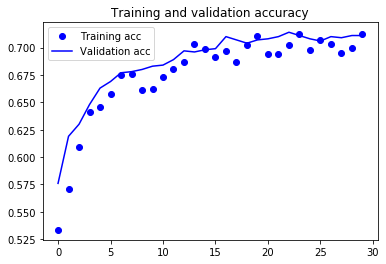

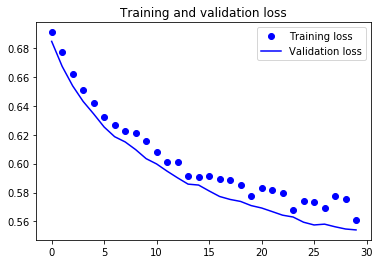

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 72%. This is much better than our small convnet trained from scratch.

## 2. Fine-tuning <a id='fine' />

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classifier wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follows:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
        
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])        
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 7,211,009
Non-trainable params: 7,635,264
_________________________________________________________________


Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 11s 107ms/step - loss: 0.5633 - acc: 0.7025 - val_loss: 0.5231 - val_acc: 0.7300
Epoch 2/100
100/100 [==============================] - 9s 90ms/step - loss: 0.5314 - acc: 0.7315 - val_loss: 0.4970 - val_acc: 0.7630
Epoch 3/100
100/100 [==============================] - 9s 94ms/step - loss: 0.5108 - acc: 0.7440 - val_loss: 0.4676 - val_acc: 0.7790
Epoch 4/100
100/100 [==============================] - 9s 90ms/step - loss: 0.5028 - acc: 0.7465 - val_loss: 0.4625 - val_acc: 0.7800
Epoch 5/100
100/100 [==============================] - 9s 90ms/step - loss: 0.4848 - acc: 0.7595 - val_loss: 0.4625 - val_acc: 0.7810
Epoch 6/100
100/100 [==============================] - 10s 97ms/step - loss: 0.4860 - acc: 0.7645 - val_loss: 0.4535 - val_acc: 0.7790
Epoch 7/100
100/100 [==============================] - 9s 91ms/step - loss: 0.4715 - acc: 0.7805 - v

100/100 [==============================] - 10s 97ms/step - loss: 0.2633 - acc: 0.8820 - val_loss: 0.4465 - val_acc: 0.8170
Epoch 60/100
100/100 [==============================] - 10s 96ms/step - loss: 0.2584 - acc: 0.8825 - val_loss: 0.4453 - val_acc: 0.8190
Epoch 61/100
100/100 [==============================] - 10s 97ms/step - loss: 0.2589 - acc: 0.8925 - val_loss: 0.4424 - val_acc: 0.8080
Epoch 62/100
100/100 [==============================] - 10s 97ms/step - loss: 0.2490 - acc: 0.8925 - val_loss: 0.4739 - val_acc: 0.7980
Epoch 63/100
100/100 [==============================] - 10s 97ms/step - loss: 0.2565 - acc: 0.8895 - val_loss: 0.4951 - val_acc: 0.7990
Epoch 64/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2382 - acc: 0.9020 - val_loss: 0.5135 - val_acc: 0.7920
Epoch 65/100
100/100 [==============================] - 10s 97ms/step - loss: 0.2439 - acc: 0.8960 - val_loss: 0.4644 - val_acc: 0.8030
Epoch 66/100
100/100 [==============================] - 10s 

In [20]:
#model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

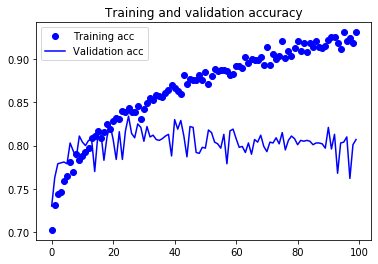

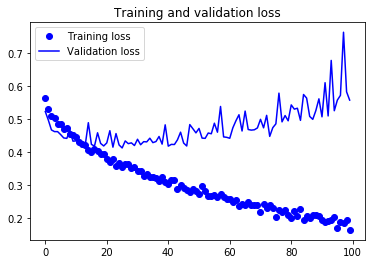

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model acuracy is now improved further to be around 80%.

We can now finally evaluate this model on the test data:

In [22]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
test acc: 0.791



Here we get a test accuracy of 80%. 

## 3. Exercise - utilize another pretrained model <a id='exc' />

Please utilize another pretrained model, e.g:
(refer https://keras.io/applications/ for details)

* Xception
* InceptionV3
* ResNet50
* VGG19
* MobileNet
* DenseNet
* NASNet

(**Note**: Different models have different requirements on minimum image size so you may need to increase `img_size` accordingly)

Implement the feature extraction, feature extraction with data augmentation and fine-tuning you learned through this practical. 

Observe the training and validation accuracy curves. 

Provide your codes & comments in the below boxes.


In [23]:
# Task 1: Feature Extraction without data augmentation


In [24]:
# Task 2: Feature Extraction with data augmentation


In [25]:
# Task 3: Fine tuning


In [26]:
# Task 4: Comments
